In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
METABO_PATH = '/net/mraid20/export/genie/LabData/Analyses/davidkro/batch_normalizations/'
DIET_PAPER_PATH = '/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/predict_MS/Optuna/Diet_paper'
tomer_dir = '/net/mraid20/export/genie/LabData/Analyses/tomerse/david_colab/'
figs_dir = '/net/mraid20/export/genie/LabData/Analyses/Metabolomics_repeat/predict_MS/Optuna/Diet_paper/Figs_paper/'

In [5]:
# Load data
food_category_baseline = pd.read_csv('./breacpntdata/food_categories_baseline.csv', index_col=0)
food_category_diff = pd.read_csv('./breacpntdata/food_categories_diff.csv', index_col=0)
food_category_followup = food_category_baseline.add(food_category_diff)

In [22]:
# drop rows with indexes in the food_category_followup not in baseline
food_category_followup = food_category_followup.loc[food_category_baseline.index]

In [33]:
food_category_baseline.to_csv('./breacpntdata/food_categories_baseline_updated.csv')
food_category_followup.to_csv('./breacpntdata/food_categories_followup_updated.csv')

In [37]:
import os
import openpyxl

def calculate_nova_scores(food_categories_file, nova_definition_file=None):
    """
    Calculate NOVA scores per sample based on food category proportions.
    
    Parameters:
    -----------
    food_categories_file : str
        Path to the CSV file containing food category proportions per sample.
    nova_definition_file : str, optional
        Path to the Excel file containing NOVA category definitions.
        If not provided, uses the default mapping defined in the function.
        
    Returns:
    --------
    pd.DataFrame
        DataFrame containing the original RegistrationCode and calculated NOVA scores.
    """
    # Read the food categories data
    food_categories = pd.read_csv(food_categories_file)
    
    # Define the NOVA mapping for each food category
    # This mapping is based on the NOVA classification system
    # NOVA 1: Unprocessed or minimally processed foods
    # NOVA 2: Processed culinary ingredients
    # NOVA 3: Processed foods
    # NOVA 4: Ultra-processed foods
    
    nova_mapping = {
        "Alcoholic Drinks": 3,
        "Beef, veal, lamb, and other meat products": 3,
        "Bread and bread products": 4,
        "Cereals": 4,
        "Drinks": 3,
        "Eggs and their products": 3,
        "Fish and seafood": 3,
        "Fruits and fruit juices": 1,  # Note: Pure fruits are NOVA 1, juices might be NOVA 3 or 4
        "Industrialized vegetarian food ready to eat": 4,
        "Med Oil and fats": 3,
        "Milk and milk products": 3,
        "Nuts, seeds, and products": 1,
        "Oils and fats": 3,
        "Others": 3,  # Default for unknown categories
        "Pasta, Grains and Side dishes  ": 3,
        "Pasta, Grains and Side dishes - Whole grains ": 3,
        "Poultry and its products": 3,
        "Pulses and products": 1,
        "Soups and sauces": 4,
        "Spices and herbs": 1,
        "Sweets, Snacks and Baked goods": 4,
        "Vegetables and their products": 1,
        "Whole grains Bread": 4,
        "Whole grains Cereals": 4,
        "left over": 3  # Default for unknown categories
    }
    
    # If a NOVA definition file is provided, update the mapping
    if nova_definition_file and os.path.exists(nova_definition_file):
        try:
            # Read the NOVA definition Excel file
            nova_df = pd.read_excel(nova_definition_file)
            
            # Update the mapping based on the Excel file
            for _, row in nova_df.iterrows():
                if pd.notna(row.get('name english')) and pd.notna(row.get('Nova score per categort ')):
                    category_name = row['name english']
                    nova_score = int(row['Nova score per categort '])
                    
                    # Find and update any matching categories in our mapping
                    for key in nova_mapping.keys():
                        if category_name.lower() in key.lower() or key.lower() in category_name.lower():
                            nova_mapping[key] = nova_score
                            break
        except Exception as e:
            print(f"Warning: Could not update NOVA mapping from file due to: {e}")
            print("Using default NOVA mapping instead.")
    
    # Initialize results DataFrame with RegistrationCode
    results = pd.DataFrame({'RegistrationCode': food_categories['RegistrationCode']})
    
    # Initialize columns for each NOVA category
    for nova in range(1, 5):
        results[f'NOVA{nova}'] = 0.0
    
    # Calculate the sum for each NOVA category for each sample
    for category, nova_score in nova_mapping.items():
        if category in food_categories.columns:
            results[f'NOVA{nova_score}'] += food_categories[category].fillna(0)
    
    # Calculate the total proportion for each sample
    results['Total'] = results['NOVA1'] + results['NOVA2'] + results['NOVA3'] + results['NOVA4']
    
    # Calculate percentages
    for nova in range(1, 5):
        results[f'NOVA{nova}_percent'] = (results[f'NOVA{nova}'] / results['Total'] * 100).round(2)
    
    # Calculate the Combined_score (weighted sum of NOVA categories)
    results['Combined_score'] = (
        results['NOVA1'] * 1 + 
        results['NOVA2'] * 2 + 
        results['NOVA3'] * 3 + 
        results['NOVA4'] * 4
    ).round(2)
    
    # Reorder the columns for better readability
    column_order = ['RegistrationCode']
    for nova in range(1, 5):
        column_order.extend([f'NOVA{nova}', f'NOVA{nova}_percent'])
    column_order.extend(['Total', 'Combined_score'])
    
    results = results[column_order]
    
    return results

def export_nova_scores(food_categories_file, output_file=None, nova_definition_file=None):
    """
    Calculate NOVA scores and export them to a CSV file.
    
    Parameters:
    -----------
    food_categories_file : str
        Path to the CSV file containing food category proportions per sample.
    output_file : str, optional
        Path to save the output CSV file. If not provided, uses the input filename with '_nova_scores' appended.
    nova_definition_file : str, optional
        Path to the Excel file containing NOVA category definitions.
        
    Returns:
    --------
    str
        Path to the saved CSV file.
    """
    # Calculate NOVA scores
    nova_scores = calculate_nova_scores(food_categories_file, nova_definition_file)
    
    # Determine output filename if not provided
    if output_file is None:
        base_name = os.path.splitext(food_categories_file)[0]
        output_file = f"{base_name}_nova_scores.csv"
    
    # Export to CSV
    nova_scores.to_csv(output_file, index=False)
    
    print(f"NOVA scores exported to {output_file}")
    return output_file

In [75]:
nova_scores_baseline = export_nova_scores("./breacpntdata/food_categories_baseline_updated.csv", nova_definition_file="./breacpntdata/Nova_per_category_definition.xlsx", output_file="./breacpntdata/Nova_scores_baseline.csv")
nova_scores_followup = export_nova_scores("./breacpntdata/food_categories_followup_updated.csv", nova_definition_file="./breacpntdata/Nova_per_category_definition.xlsx", output_file="./breacpntdata/Nova_scores_followup.csv")

NOVA scores exported to ./breacpntdata/Nova_scores_baseline.csv
NOVA scores exported to ./breacpntdata/Nova_scores_followup.csv


In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

def plot_nova_trajectory(predictions_file, baseline_barcodes_file, followup_barcodes_file, 
                         nova_baseline_file, nova_followup_file,
                         x_metric='NOVA1_percent', y_metric='NOVA4_percent', 
                         diet_filter=None, output_file=None, figsize=(10, 8)):
    """
    Create a NOVA score trajectory plot showing baseline, follow-up, and predicted endpoints.
    
    Parameters:
    -----------
    predictions_file : str
        Path to CSV file containing prediction data
    baseline_barcodes_file : str
        Path to CSV file containing baseline tube barcodes
    followup_barcodes_file : str
        Path to CSV file containing follow-up tube barcodes
    nova_baseline_file : str
        Path to CSV file containing baseline NOVA scores
    nova_followup_file : str
        Path to CSV file containing follow-up NOVA scores
    x_metric : str
        Column name to use for x-axis in NOVA files (default: 'NOVA1_percent')
    y_metric : str
        Column name to use for y-axis in NOVA files (default: 'NOVA4_percent')
    diet_filter : str, optional
        Filter to a specific diet group if provided
    output_file : str, optional
        Path to save the figure if provided
    figsize : tuple
        Figure size (width, height) in inches
        
    Returns:
    --------
    matplotlib.figure.Figure
        The figure object containing the plot
    """
    # Define mapping between NOVA file columns and prediction file columns
    nova_to_pred_mapping = {
        'NOVA1': 'Group 1',
        'NOVA2': 'Group 2',  # If exists in predictions
        'NOVA3': 'Group 3',
        'NOVA4': 'Group 4',
        'Combined_score': 'Combined_score'
    }
    
    # Get corresponding prediction column names
    x_pred_metric = nova_to_pred_mapping.get(x_metric, x_metric)
    y_pred_metric = nova_to_pred_mapping.get(y_metric, y_metric)
    
    # Load data files
    predictions_df = pd.read_csv(predictions_file)
    baseline_barcodes_df = pd.read_csv(baseline_barcodes_file)
    followup_barcodes_df = pd.read_csv(followup_barcodes_file)
    nova_baseline_df = pd.read_csv(nova_baseline_file)
    nova_followup_df = pd.read_csv(nova_followup_file)
    
    # Ensure barcode DataFrames have the expected columns
    expected_cols_barcodes = ['RegistrationCode', 'Updated Tube Barcode']
    if not all(col in baseline_barcodes_df.columns for col in expected_cols_barcodes):
        raise ValueError("Baseline barcodes file missing required columns")
    if not all(col in followup_barcodes_df.columns for col in expected_cols_barcodes):
        raise ValueError("Followup barcodes file missing required columns")
    
    # Ensure Nova DataFrames have the expected columns
    expected_cols_nova = ['RegistrationCode', x_metric, y_metric]
    if not all(col in nova_baseline_df.columns for col in expected_cols_nova):
        missing = [col for col in expected_cols_nova if col not in nova_baseline_df.columns]
        raise ValueError(f"Missing columns in Nova baseline file: {missing}")
    if not all(col in nova_followup_df.columns for col in expected_cols_nova):
        missing = [col for col in expected_cols_nova if col not in nova_followup_df.columns]
        raise ValueError(f"Missing columns in Nova followup file: {missing}")
    
    # Check prediction columns
    expected_cols_pred = ['index', x_pred_metric, y_pred_metric]
    if not all(col in predictions_df.columns for col in expected_cols_pred):
        missing = [col for col in expected_cols_pred if col not in predictions_df.columns]
        raise ValueError(f"Missing columns in predictions file: {missing}")
    
    # Create maps for quick access
    baseline_barcode_map = dict(zip(baseline_barcodes_df['RegistrationCode'], baseline_barcodes_df['Updated Tube Barcode']))
    followup_barcode_map = dict(zip(followup_barcodes_df['RegistrationCode'], followup_barcodes_df['Updated Tube Barcode']))
    nova_baseline_map = {row['RegistrationCode']: row for _, row in nova_baseline_df.iterrows()}
    nova_followup_map = {row['RegistrationCode']: row for _, row in nova_followup_df.iterrows()}
    
    # Create a dict mapping barcode to predictions
    predictions_map = {row['index']: row for _, row in predictions_df.iterrows()}
    
    # Create trajectories dataset
    trajectories = []
    
    # Loop through registration codes
    reg_codes = set(baseline_barcodes_df['RegistrationCode']).intersection(
        set(followup_barcodes_df['RegistrationCode'])).intersection(
        set(nova_baseline_df['RegistrationCode'])).intersection(
        set(nova_followup_df['RegistrationCode']))
    
    for reg_code in reg_codes:
        baseline_barcode = baseline_barcode_map.get(reg_code)
        followup_barcode = followup_barcode_map.get(reg_code)
        
        # Skip if we don't have both barcodes
        if not baseline_barcode or not followup_barcode:
            continue
            
        # Skip if we don't have Nova data for both timepoints
        if reg_code not in nova_baseline_map or reg_code not in nova_followup_map:
            continue
            
        # Get NOVA score data
        baseline_nova_data = nova_baseline_map[reg_code]
        followup_nova_data = nova_followup_map[reg_code]
        
        # Initialize trajectory data with available NOVA scores
        trajectory_data = {
            'reg_code': reg_code,
            'baseline_barcode': baseline_barcode,
            'followup_barcode': followup_barcode,
            'baseline_x': baseline_nova_data[x_metric],
            'baseline_y': baseline_nova_data[y_metric],
            'followup_x': followup_nova_data[x_metric],
            'followup_y': followup_nova_data[y_metric]
        }
        
        # Add prediction data if available
        if baseline_barcode in predictions_map:
            baseline_pred_data = predictions_map[baseline_barcode]
            if x_pred_metric in baseline_pred_data and y_pred_metric in baseline_pred_data:
                trajectory_data['predicted_x'] = baseline_pred_data[x_pred_metric]
                trajectory_data['predicted_y'] = baseline_pred_data[y_pred_metric]
        
        trajectories.append(trajectory_data)
    
    # Convert to DataFrame
    trajectory_df = pd.DataFrame(trajectories)
    
    # Apply diet filter if provided
    if diet_filter:
        # Here you would filter the trajectory_df based on diet information
        # Since the diet information is not in the provided files, this is a placeholder
        pass
    
    # Check if we have prediction data
    has_predictions = all(col in trajectory_df.columns for col in ['predicted_x', 'predicted_y']) and \
                      not trajectory_df['predicted_x'].isna().all() and \
                      not trajectory_df['predicted_y'].isna().all()
    
    # Calculate R-squared between predicted and actual endpoints if predictions available
    r_squared = 0
    if has_predictions and len(trajectory_df) > 0:
        # Filter out rows with missing predictions
        valid_predictions = trajectory_df.dropna(subset=['predicted_x', 'predicted_y']).copy()
        
        if len(valid_predictions) > 0:
            # Calculate Euclidean distance between predicted and actual points using proper loc assignment
            valid_predictions.loc[:, 'predicted_distance'] = np.sqrt(
                (valid_predictions['predicted_x'] - valid_predictions['followup_x'])**2 + 
                (valid_predictions['predicted_y'] - valid_predictions['followup_y'])**2
            )
            
            # Calculate R-squared
            predicted_coords = valid_predictions[['predicted_x', 'predicted_y']].values
            actual_coords = valid_predictions[['followup_x', 'followup_y']].values
            
            # Calculate mean of actual values
            mean_actual_x = np.mean(actual_coords[:, 0])
            mean_actual_y = np.mean(actual_coords[:, 1])
            
            # Calculate total sum of squares
            ss_total = np.sum((actual_coords[:, 0] - mean_actual_x)**2 + 
                              (actual_coords[:, 1] - mean_actual_y)**2)
            
            # Calculate residual sum of squares
            ss_residual = np.sum((actual_coords[:, 0] - predicted_coords[:, 0])**2 + 
                                 (actual_coords[:, 1] - predicted_coords[:, 1])**2)
            
            # Calculate R-squared
            r_squared = 1 - (ss_residual / ss_total) if ss_total > 0 else 0
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Set styles
    sns.set_style("whitegrid")
    
    # Plot actual trajectories (baseline to actual follow-up)
    for _, row in trajectory_df.iterrows():
        ax.plot([row['baseline_x'], row['followup_x']], 
                [row['baseline_y'], row['followup_y']], 
                color='green', alpha=0.4, linestyle='-',
                linewidth=1.5)
    
    # Plot predicted trajectories if available
    if has_predictions:
        for _, row in trajectory_df.dropna(subset=['predicted_x', 'predicted_y']).iterrows():
            ax.plot([row['baseline_x'], row['predicted_x']], 
                    [row['baseline_y'], row['predicted_y']], 
                    color='purple', alpha=0.4, linestyle='--',
                    linewidth=1.5)
    
    # Plot baseline points
    sns.scatterplot(
        x='baseline_x', y='baseline_y', 
        data=trajectory_df, 
        color='blue', s=80, alpha=0.7, 
        label='Baseline', ax=ax
    )
    
    # Plot actual follow-up points
    sns.scatterplot(
        x='followup_x', y='followup_y', 
        data=trajectory_df, 
        color='orange', s=80, alpha=0.7, 
        label='Actual Follow-Up', ax=ax
    )
    
    # Plot predicted follow-up endpoints if available
    if has_predictions:
        sns.scatterplot(
            x='predicted_x', y='predicted_y', 
            data=trajectory_df.dropna(subset=['predicted_x', 'predicted_y']), 
            color='purple', s=100, alpha=0.9, 
            marker='D',  # Diamond shape to make it more visible
            label='Predicted Follow-Up', ax=ax
        )
    
    # Create human-readable metric names for axis labels
    x_label_mapping = {
        'NOVA1_percent': 'NOVA Group 1 (%)',
        'NOVA2_percent': 'NOVA Group 2 (%)',
        'NOVA3_percent': 'NOVA Group 3 (%)',
        'NOVA4_percent': 'NOVA Group 4 (%)',
        'Combined_score': 'Combined Score'
    }
    
    y_label_mapping = x_label_mapping.copy()
    
    x_label = x_label_mapping.get(x_metric, x_metric.replace('_', ' ').title())
    y_label = y_label_mapping.get(y_metric, y_metric.replace('_', ' ').title())
    
    # Set plot labels and title
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_title('NOVA Score Trajectory Plot', fontsize=16)
    
    # Add R-squared annotation if predictions exist
    if has_predictions:
        ax.text(0.05, 0.05, f'Prediction R² = {r_squared:.2f}', 
                transform=ax.transAxes, fontsize=12, 
                bbox=dict(facecolor='white', alpha=0.7))
    
    # Create legend elements
    legend_elements = [
        mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Baseline'),
        mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Actual Follow-Up'),
        mlines.Line2D([0], [0], color='green', linestyle='-', linewidth=2, label='Actual Trajectory')
    ]
    
    # Add prediction elements to legend if available
    if has_predictions:
        legend_elements.extend([
            mlines.Line2D([0], [0], marker='D', color='w', markerfacecolor='purple', markersize=10, label='Predicted Follow-Up'),
            mlines.Line2D([0], [0], color='purple', linestyle='--', linewidth=2, label='Predicted Trajectory')
        ])
    
    ax.legend(handles=legend_elements, loc='upper center', 
              bbox_to_anchor=(0.5, -0.15), ncol=3)
    
    # Add a descriptive note
    if has_predictions:
        plt.figtext(0.5, 0.01, 'Compares actual NOVA score trajectories (solid green) with predicted trajectories (dashed purple)', 
                    ha='center', fontsize=10)
    else:
        plt.figtext(0.5, 0.01, 'Shows actual NOVA score trajectories over time', 
                    ha='center', fontsize=10)
    
    # Set equal aspect ratio to make distances visually accurate
    ax.set_aspect('equal')
    
    # Add diet selector information if provided
    if diet_filter:
        plt.figtext(0.95, 0.95, f'Diet: {diet_filter}', 
                   ha='right', fontsize=12, 
                   bbox=dict(facecolor='white', alpha=0.7))
    
    # Adjust layout
    plt.tight_layout()
    
    # Save figure if output file is provided
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
    
    return fig



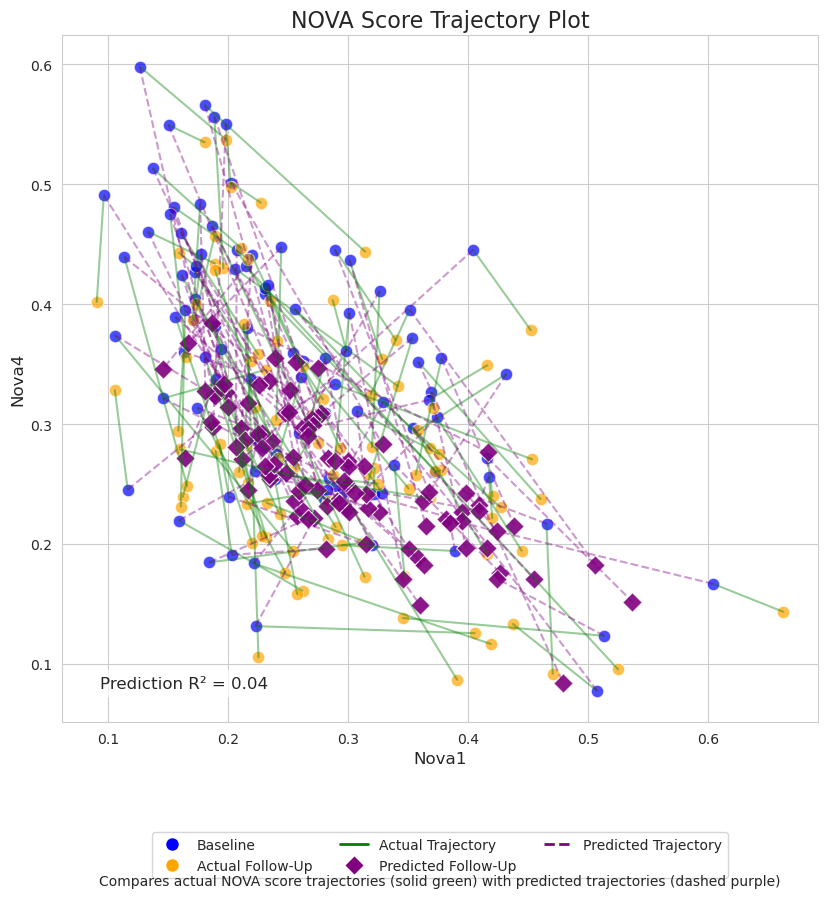

In [83]:
# Basic usage example
fig = plot_nova_trajectory(
    predictions_file='./breacpntdata/full_predictions.csv',
    baseline_barcodes_file='./breacpntdata/bc_baseline_tube_barcodes.csv',
    followup_barcodes_file='./breacpntdata/bc_followup_tube_barcodes.csv',
    nova_baseline_file='./breacpntdata/Nova_scores_baseline.csv',
    nova_followup_file='./breacpntdata/Nova_scores_followup.csv',
    x_metric='NOVA1',
    y_metric='NOVA4',
    figsize=(12, 9),
    output_file='./breacpntdata/nova_trajectory_plot_new.png'
)
plt.show()

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def plot_prediction_comparisons(predictions_file, baseline_barcodes_file, followup_barcodes_file, 
                               nova_baseline_file, nova_followup_file,
                               metric='NOVA1_percent', output_dir=None, figsize=(12, 4)):
    """
    Create three plots comparing predicted vs true values for a given metric:
    1. Baseline predicted vs. baseline true
    2. Followup predicted vs. followup true
    3. Difference predicted vs. difference true
    
    Parameters:
    -----------
    predictions_file : str
        Path to CSV file containing prediction data
    baseline_barcodes_file : str
        Path to CSV file containing baseline tube barcodes
    followup_barcodes_file : str
        Path to CSV file containing follow-up tube barcodes
    nova_baseline_file : str
        Path to CSV file containing baseline NOVA scores
    nova_followup_file : str
        Path to CSV file containing follow-up NOVA scores
    metric : str
        Column name to analyze in NOVA files (default: 'NOVA1_percent')
    output_dir : str, optional
        Directory to save the figures if provided
    figsize : tuple
        Figure size (width, height) in inches for each subplot
        
    Returns:
    --------
    tuple of matplotlib.figure.Figure
        The three figure objects containing the plots
    """
    # Define mapping between NOVA file columns and prediction file columns
    nova_to_pred_mapping = {
        # With percent
        'NOVA1_percent': 'Group 1',
        'NOVA2_percent': 'Group 2',  # If exists in predictions
        'NOVA3_percent': 'Group 3',
        'NOVA4_percent': 'Group 4',
        'Combined_score': 'Combined_score',
        # Without percent
        'NOVA1': 'Group 1',
        'NOVA2': 'Group 2',  # If exists in predictions
        'NOVA3': 'Group 3',
        'NOVA4': 'Group 4'
    }
    
    # Get corresponding prediction column name
    pred_metric = nova_to_pred_mapping.get(metric, metric)
    
    # Define human-readable label for the metric
    metric_label_mapping = {
        # With percent
        'NOVA1_percent': 'NOVA Group 1 (%)',
        'NOVA2_percent': 'NOVA Group 2 (%)',
        'NOVA3_percent': 'NOVA Group 3 (%)',
        'NOVA4_percent': 'NOVA Group 4 (%)',
        'Combined_score': 'Combined Score',
        # Without percent
        'NOVA1': 'NOVA Group 1',
        'NOVA2': 'NOVA Group 2',
        'NOVA3': 'NOVA Group 3',
        'NOVA4': 'NOVA Group 4'
    }
    metric_label = metric_label_mapping.get(metric, metric.replace('_', ' ').title())
    
    # Load data files
    predictions_df = pd.read_csv(predictions_file)
    baseline_barcodes_df = pd.read_csv(baseline_barcodes_file)
    followup_barcodes_df = pd.read_csv(followup_barcodes_file)
    nova_baseline_df = pd.read_csv(nova_baseline_file)
    nova_followup_df = pd.read_csv(nova_followup_file)
    
    # Ensure all required columns exist
    if pred_metric not in predictions_df.columns:
        raise ValueError(f"Prediction column '{pred_metric}' not found in predictions file")
    if f"{pred_metric}_true" not in predictions_df.columns:
        raise ValueError(f"True column '{pred_metric}_true' not found in predictions file")
    if metric not in nova_baseline_df.columns:
        raise ValueError(f"Metric '{metric}' not found in baseline NOVA file")
    if metric not in nova_followup_df.columns:
        raise ValueError(f"Metric '{metric}' not found in followup NOVA file")
    
    # Create maps for quick access
    baseline_barcode_map = dict(zip(baseline_barcodes_df['RegistrationCode'], baseline_barcodes_df['Updated Tube Barcode']))
    followup_barcode_map = dict(zip(followup_barcodes_df['RegistrationCode'], followup_barcodes_df['Updated Tube Barcode']))
    nova_baseline_map = {row['RegistrationCode']: row for _, row in nova_baseline_df.iterrows()}
    nova_followup_map = {row['RegistrationCode']: row for _, row in nova_followup_df.iterrows()}
    
    # Create dicts mapping barcode to predictions
    predictions_map = {row['index']: row for _, row in predictions_df.iterrows()}
    
    # Create dataset for comparison
    comparison_data = []
    
    # Loop through registration codes
    reg_codes = set(baseline_barcodes_df['RegistrationCode']).intersection(
        set(followup_barcodes_df['RegistrationCode'])).intersection(
        set(nova_baseline_df['RegistrationCode'])).intersection(
        set(nova_followup_df['RegistrationCode']))
    
    for reg_code in reg_codes:
        baseline_barcode = baseline_barcode_map.get(reg_code)
        followup_barcode = followup_barcode_map.get(reg_code)
        
        # Skip if we don't have both barcodes
        if not baseline_barcode or not followup_barcode:
            continue
            
        # Skip if we don't have Nova data for both timepoints
        if reg_code not in nova_baseline_map or reg_code not in nova_followup_map:
            continue
            
        # Skip if we don't have predictions for both timepoints
        if baseline_barcode not in predictions_map or followup_barcode not in predictions_map:
            continue
            
        # Get prediction data
        baseline_pred_data = predictions_map[baseline_barcode]
        followup_pred_data = predictions_map[followup_barcode]
        
        # Get NOVA score data
        baseline_nova_data = nova_baseline_map[reg_code]
        followup_nova_data = nova_followup_map[reg_code]
        
        # Extract metrics
        baseline_true = baseline_nova_data[metric]
        followup_true = followup_nova_data[metric]
        baseline_pred = baseline_pred_data.get(pred_metric)
        followup_pred = followup_pred_data.get(pred_metric)
        
        # Skip if any value is missing
        if any(pd.isna(val) for val in [baseline_true, followup_true, baseline_pred, followup_pred]):
            continue
        
        # Calculate differences
        true_diff = followup_true - baseline_true
        pred_diff = followup_pred - baseline_pred
        
        # Add to comparison data
        comparison_data.append({
            'reg_code': reg_code,
            'baseline_true': baseline_true,
            'baseline_pred': baseline_pred,
            'followup_true': followup_true,
            'followup_pred': followup_pred,
            'true_diff': true_diff,
            'pred_diff': pred_diff
        })
    
    # Convert to DataFrame
    comparison_df = pd.DataFrame(comparison_data)
    
    if len(comparison_df) == 0:
        raise ValueError("No valid comparison data found after filtering")
    
    # Create figure 1: Baseline Predicted vs. Baseline True
    fig1, ax1 = plt.subplots(figsize=figsize)
    sns.regplot(x='baseline_true', y='baseline_pred', data=comparison_df, scatter_kws={'alpha':0.6}, line_kws={'color':'red'}, ax=ax1)
    
    # Add identity line (y=x)
    min_val = min(comparison_df['baseline_true'].min(), comparison_df['baseline_pred'].min())
    max_val = max(comparison_df['baseline_true'].max(), comparison_df['baseline_pred'].max())
    padding = (max_val - min_val) * 0.05
    ax1.plot([min_val-padding, max_val+padding], [min_val-padding, max_val+padding], 'k--', alpha=0.5)
    
    # Calculate metrics
    r2 = r2_score(comparison_df['baseline_true'], comparison_df['baseline_pred'])
    mae = mean_absolute_error(comparison_df['baseline_true'], comparison_df['baseline_pred'])
    rmse = np.sqrt(mean_squared_error(comparison_df['baseline_true'], comparison_df['baseline_pred']))
    
    # Add metrics text
    ax1.text(0.05, 0.95, f'R² = {r2:.3f}\nMAE = {mae:.3f}\nRMSE = {rmse:.3f}', 
             transform=ax1.transAxes, fontsize=10, 
             bbox=dict(facecolor='white', alpha=0.7), verticalalignment='top')
    
    ax1.set_xlabel(f'Baseline True {metric_label}')
    ax1.set_ylabel(f'Baseline Predicted {metric_label}')
    ax1.set_title(f'Baseline: Predicted vs. True {metric_label}')
    fig1.tight_layout()
    
    # Create figure 2: Followup Predicted vs. Followup True
    fig2, ax2 = plt.subplots(figsize=figsize)
    sns.regplot(x='followup_true', y='followup_pred', data=comparison_df, scatter_kws={'alpha':0.6}, line_kws={'color':'red'}, ax=ax2)
    
    # Add identity line (y=x)
    min_val = min(comparison_df['followup_true'].min(), comparison_df['followup_pred'].min())
    max_val = max(comparison_df['followup_true'].max(), comparison_df['followup_pred'].max())
    padding = (max_val - min_val) * 0.05
    ax2.plot([min_val-padding, max_val+padding], [min_val-padding, max_val+padding], 'k--', alpha=0.5)
    
    # Calculate metrics
    r2 = r2_score(comparison_df['followup_true'], comparison_df['followup_pred'])
    mae = mean_absolute_error(comparison_df['followup_true'], comparison_df['followup_pred'])
    rmse = np.sqrt(mean_squared_error(comparison_df['followup_true'], comparison_df['followup_pred']))
    
    # Add metrics text
    ax2.text(0.05, 0.95, f'R² = {r2:.3f}\nMAE = {mae:.3f}\nRMSE = {rmse:.3f}', 
             transform=ax2.transAxes, fontsize=10, 
             bbox=dict(facecolor='white', alpha=0.7), verticalalignment='top')
    
    ax2.set_xlabel(f'Follow-up True {metric_label}')
    ax2.set_ylabel(f'Follow-up Predicted {metric_label}')
    ax2.set_title(f'Follow-up: Predicted vs. True {metric_label}')
    fig2.tight_layout()
    
    # Create figure 3: Difference Predicted vs. Difference True
    fig3, ax3 = plt.subplots(figsize=figsize)
    sns.regplot(x='true_diff', y='pred_diff', data=comparison_df, scatter_kws={'alpha':0.6}, line_kws={'color':'red'}, ax=ax3)
    
    # Add identity line (y=x)
    min_val = min(comparison_df['true_diff'].min(), comparison_df['pred_diff'].min())
    max_val = max(comparison_df['true_diff'].max(), comparison_df['pred_diff'].max())
    padding = (max_val - min_val) * 0.05
    ax3.plot([min_val-padding, max_val+padding], [min_val-padding, max_val+padding], 'k--', alpha=0.5)
    
    # Calculate metrics
    r2 = r2_score(comparison_df['true_diff'], comparison_df['pred_diff'])
    mae = mean_absolute_error(comparison_df['true_diff'], comparison_df['pred_diff'])
    rmse = np.sqrt(mean_squared_error(comparison_df['true_diff'], comparison_df['pred_diff']))
    
    # Add metrics text
    ax3.text(0.05, 0.95, f'R² = {r2:.3f}\nMAE = {mae:.3f}\nRMSE = {rmse:.3f}', 
             transform=ax3.transAxes, fontsize=10, 
             bbox=dict(facecolor='white', alpha=0.7), verticalalignment='top')
    
    # Add horizontal and vertical lines at zero
    ax3.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    ax3.axvline(x=0, color='gray', linestyle='-', alpha=0.3)
    
    ax3.set_xlabel(f'True Difference in {metric_label}')
    ax3.set_ylabel(f'Predicted Difference in {metric_label}')
    ax3.set_title(f'Difference: Predicted vs. True {metric_label}')
    fig3.tight_layout()
    
    # Save figures if output directory is provided
    if output_dir:
        import os
        metric_name = metric.replace('%', 'pct').replace(' ', '_')
        fig1.savefig(os.path.join(output_dir, f'baseline_{metric_name}_comparison.png'), dpi=300, bbox_inches='tight')
        fig2.savefig(os.path.join(output_dir, f'followup_{metric_name}_comparison.png'), dpi=300, bbox_inches='tight')
        fig3.savefig(os.path.join(output_dir, f'difference_{metric_name}_comparison.png'), dpi=300, bbox_inches='tight')
    
    return fig1, fig2, fig3


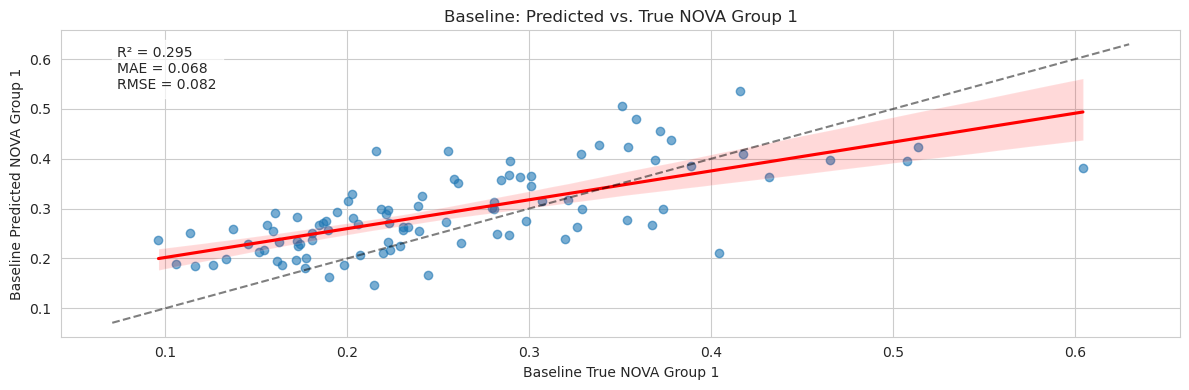

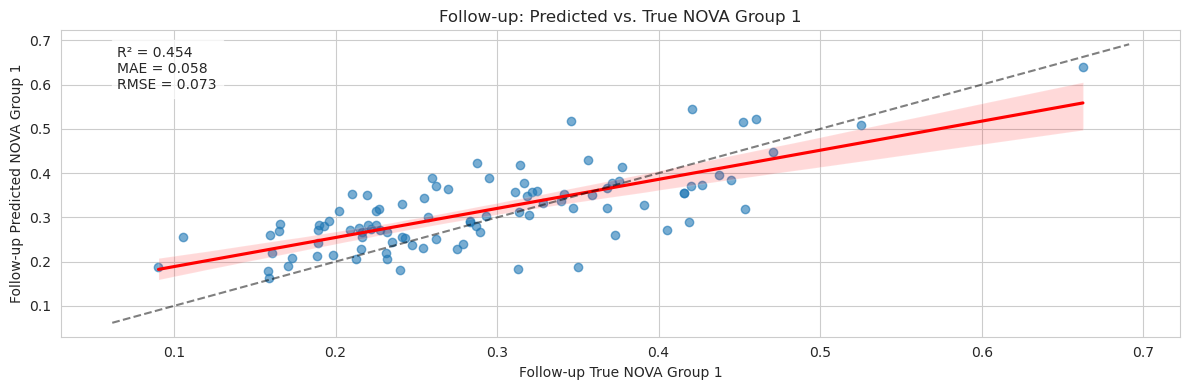

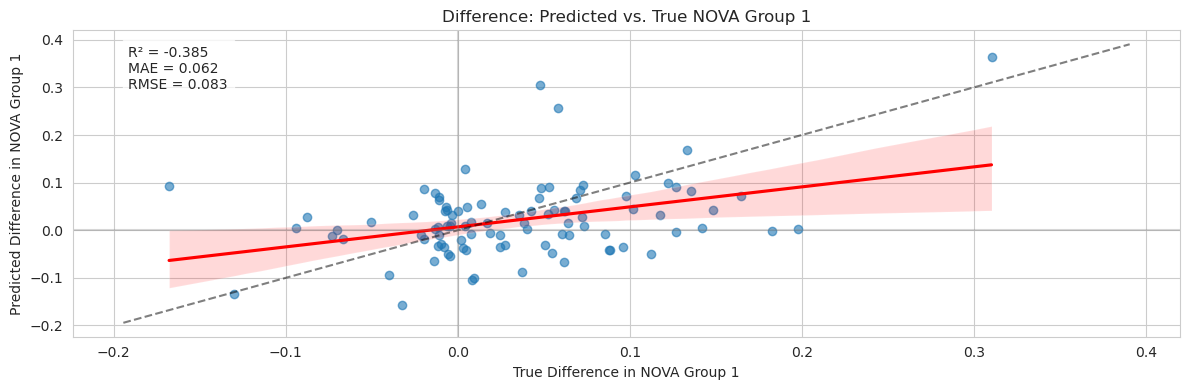

In [94]:
# Basic usage example
fig1, fig2, fig3 = plot_prediction_comparisons(
    predictions_file='./breacpntdata/full_predictions.csv',
    baseline_barcodes_file='./breacpntdata/bc_baseline_tube_barcodes.csv',
    followup_barcodes_file='./breacpntdata/bc_followup_tube_barcodes.csv',
    nova_baseline_file='./breacpntdata/Nova_scores_baseline.csv',
    nova_followup_file='./breacpntdata/Nova_scores_followup.csv',
    metric='NOVA1',
    output_dir='./breacpntdata/',
)

In [23]:
def plot_improved_comparison(predictions_file, baseline_barcodes_file, followup_barcodes_file, 
                            nova_baseline_file, nova_followup_file,
                            metric='NOVA1_percent', output_file=None, figsize=(12, 10),
                            focus_mode=False, focus_threshold=0.1, scatter_size=50, metric_label=None):
    """
    Create an improved readable plot showing both baseline and follow-up predicted vs true values
    with color-coded follow-up points based on allocation group.
    
    Parameters:
    -----------
    predictions_file : str
        Path to CSV file containing prediction data
    baseline_barcodes_file : str
        Path to CSV file containing baseline tube barcodes
    followup_barcodes_file : str
        Path to CSV file containing follow-up tube barcodes with 'alloc' column
        (1 = Personalized Intervention, 0 = Mediterranean diet)
    nova_baseline_file : str
        Path to CSV file containing baseline NOVA scores
    nova_followup_file : str
        Path to CSV file containing follow-up NOVA scores
    metric : str
        Column name to analyze in NOVA files (default: 'NOVA1_percent')
    output_file : str, optional
        Path to save the figure if provided
    figsize : tuple
        Figure size (width, height) in inches
    focus_mode : bool
        If True, only show subjects with significant changes (determined by focus_threshold)
    focus_threshold : float
        Threshold for significant changes when focus_mode is True
        
    Returns:
    --------
    matplotlib.figure.Figure
        The figure object containing the plot
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import r2_score
    
    # Define mapping between NOVA file columns and prediction file columns
    nova_to_pred_mapping = {
        # With percent
        'NOVA1_percent': 'Group 1',
        'NOVA2_percent': 'Group 2',  # If exists in predictions
        'NOVA3_percent': 'Group 3',
        'NOVA4_percent': 'Group 4',
        'Combined_score': 'Combined_score',
        # Without percent
        'NOVA1': 'Group 1',
        'NOVA2': 'Group 2',  # If exists in predictions
        'NOVA3': 'Group 3',
        'NOVA4': 'Group 4'
    }
    
    # Get corresponding prediction column name
    pred_metric = nova_to_pred_mapping.get(metric, metric)
    
    # Define human-readable label for the metric
    metric_label_mapping = {
        # With percent
        'NOVA1_percent': 'NOVA Group 1 (%)',
        'NOVA2_percent': 'NOVA Group 2 (%)',
        'NOVA3_percent': 'NOVA Group 3 (%)',
        'NOVA4_percent': 'NOVA Group 4 (%)',
        'Combined_score': 'Combined Score',
        # Without percent
        'NOVA1': 'NOVA Group 1',
        'NOVA2': 'NOVA Group 2',
        'NOVA3': 'NOVA Group 3',
        'NOVA4': 'NOVA Group 4'
    }
    
    if metric_label is None:
        metric_label = metric_label_mapping.get(metric, metric.replace('_', ' ').title())
    
    # Load data files
    predictions_df = pd.read_csv(predictions_file)
    baseline_barcodes_df = pd.read_csv(baseline_barcodes_file)
    followup_barcodes_df = pd.read_csv(followup_barcodes_file)
    nova_baseline_df = pd.read_csv(nova_baseline_file)
    nova_followup_df = pd.read_csv(nova_followup_file)
    
    # Check if alloc column exists in followup_barcodes_file
    if 'alloc' not in followup_barcodes_df.columns:
        raise ValueError("Column 'alloc' not found in followup_barcodes_file")
    
    # Ensure all required columns exist
    if pred_metric not in predictions_df.columns:
        raise ValueError(f"Prediction column '{pred_metric}' not found in predictions file")
    if f"{pred_metric}_true" not in predictions_df.columns:
        raise ValueError(f"True column '{pred_metric}_true' not found in predictions file")
    if metric not in nova_baseline_df.columns:
        raise ValueError(f"Metric '{metric}' not found in baseline NOVA file")
    if metric not in nova_followup_df.columns:
        raise ValueError(f"Metric '{metric}' not found in followup NOVA file")
    
    # Create maps for quick access
    baseline_barcode_map = dict(zip(baseline_barcodes_df['RegistrationCode'], baseline_barcodes_df['Updated Tube Barcode']))
    followup_barcode_map = dict(zip(followup_barcodes_df['RegistrationCode'], followup_barcodes_df['Updated Tube Barcode']))
    followup_alloc_map = dict(zip(followup_barcodes_df['RegistrationCode'], followup_barcodes_df['alloc']))
    nova_baseline_map = {row['RegistrationCode']: row for _, row in nova_baseline_df.iterrows()}
    nova_followup_map = {row['RegistrationCode']: row for _, row in nova_followup_df.iterrows()}
    
    # Create dicts mapping barcode to predictions
    predictions_map = {row['index']: row for _, row in predictions_df.iterrows()}
    
    # Create paired dataset for connected dots
    pairs_data = []
    
    # Loop through registration codes
    reg_codes = set(baseline_barcodes_df['RegistrationCode']).intersection(
        set(followup_barcodes_df['RegistrationCode'])).intersection(
        set(nova_baseline_df['RegistrationCode'])).intersection(
        set(nova_followup_df['RegistrationCode']))
    
    for reg_code in reg_codes:
        baseline_barcode = baseline_barcode_map.get(reg_code)
        followup_barcode = followup_barcode_map.get(reg_code)
        
        # Skip if we don't have both barcodes
        if not baseline_barcode or not followup_barcode:
            continue
            
        # Skip if we don't have Nova data for both timepoints
        if reg_code not in nova_baseline_map or reg_code not in nova_followup_map:
            continue
            
        # Skip if we don't have predictions for both timepoints
        if baseline_barcode not in predictions_map or followup_barcode not in predictions_map:
            continue
            
        # Get prediction data
        baseline_pred_data = predictions_map[baseline_barcode]
        followup_pred_data = predictions_map[followup_barcode]
        
        # Get NOVA score data
        baseline_nova_data = nova_baseline_map[reg_code]
        followup_nova_data = nova_followup_map[reg_code]
        
        # Get allocation group
        allocation = followup_alloc_map.get(reg_code)
        
        # Skip if allocation is missing
        if allocation is None:
            continue
        
        # Extract metrics
        baseline_true = baseline_nova_data[metric]
        followup_true = followup_nova_data[metric]
        baseline_pred = baseline_pred_data.get(pred_metric)
        followup_pred = followup_pred_data.get(pred_metric)
        
        # Skip if any value is missing
        if any(pd.isna(val) for val in [baseline_true, followup_true, baseline_pred, followup_pred, allocation]):
            continue
        
        # Determine if true value increased or decreased
        true_value_increased = followup_true > baseline_true
        
        # Calculate magnitude of change for focus mode
        true_change = abs(followup_true - baseline_true)
        pred_change = abs(followup_pred - baseline_pred)
        
        # Add paired data
        pairs_data.append({
            'reg_code': reg_code,
            'baseline_true': baseline_true,
            'baseline_pred': baseline_pred,
            'followup_true': followup_true,
            'followup_pred': followup_pred,
            'true_value_increased': true_value_increased,
            'true_change': true_change,
            'pred_change': pred_change,
            'allocation': int(allocation)  # Ensure it's an integer
        })
    
    # Convert to DataFrame
    pairs_df = pd.DataFrame(pairs_data)
    
    # Apply focus mode filtering if requested
    if focus_mode and len(pairs_df) > 0:
        # Keep only subjects with significant changes
        pairs_df = pairs_df[(pairs_df['true_change'] > focus_threshold) | 
                           (pairs_df['pred_change'] > focus_threshold)]
    
    if len(pairs_df) == 0:
        raise ValueError("No valid comparison data found after filtering")
    
    # Calculate R² scores for baseline and follow-up predictions
    baseline_r2 = r2_score(pairs_df['baseline_true'], pairs_df['baseline_pred'])
    
    # Calculate R² scores separately for each allocation group
    personalized_df = pairs_df[pairs_df['allocation'] == 1]
    mediterranean_df = pairs_df[pairs_df['allocation'] == 0]
    
    # Print group sizes
    print(f"Total number of matched samples: {len(pairs_df)}")
    print(f"Number of Personalized group samples: {len(personalized_df)}")
    print(f"Number of Mediterranean group samples: {len(mediterranean_df)}")

    
    personalized_r2 = r2_score(personalized_df['followup_true'], personalized_df['followup_pred']) if len(personalized_df) > 1 else float('nan')
    mediterranean_r2 = r2_score(mediterranean_df['followup_true'], mediterranean_df['followup_pred']) if len(mediterranean_df) > 1 else float('nan')
    
    # Add small jitter to help with overlapping points
    np.random.seed(42)  # For reproducibility
    jitter_amount = 0.002
    pairs_df['baseline_true_jittered'] = pairs_df['baseline_true'] + np.random.uniform(-jitter_amount, jitter_amount, len(pairs_df))
    pairs_df['baseline_pred_jittered'] = pairs_df['baseline_pred'] + np.random.uniform(-jitter_amount, jitter_amount, len(pairs_df))
    pairs_df['followup_true_jittered'] = pairs_df['followup_true'] + np.random.uniform(-jitter_amount, jitter_amount, len(pairs_df))
    pairs_df['followup_pred_jittered'] = pairs_df['followup_pred'] + np.random.uniform(-jitter_amount, jitter_amount, len(pairs_df))
    
    # Create the plot with white background
    fig, ax = plt.subplots(figsize=figsize, facecolor='white')
    ax.set_facecolor('white')
    
    # Use a nicer color palette - Baseline in a softer blue
    baseline_color = '#2196F3'  # A softer blue
    
    # Plot the scatter points for baseline
    ax.scatter(pairs_df['baseline_true_jittered'], pairs_df['baseline_pred_jittered'], 
              c=baseline_color, alpha=0.7, s=scatter_size, label=f'Baseline (R² = {baseline_r2:.3f})')
    
    # Plot the scatter points for follow-up colored by allocation
    # Make sure personalized_df and mediterranean_df have access to the jittered columns
    # by filtering from pairs_df after jittering
    personalized_df = pairs_df[pairs_df['allocation'] == 1]
    mediterranean_df = pairs_df[pairs_df['allocation'] == 0]
    
    # Use a nicer color palette
    personalized_color = '#FF9800'  # A pleasant green
    mediterranean_color = '#4CAF50'  # A pleasant red
    
    personalized_scatter = ax.scatter(
        personalized_df['followup_true_jittered'], 
        personalized_df['followup_pred_jittered'], 
        c=personalized_color, alpha=0.7, s=scatter_size, marker='D', 
        label=f'Follow-up: Personalized (R² = {personalized_r2:.3f})'
    )
    
    mediterranean_scatter = ax.scatter(
        mediterranean_df['followup_true_jittered'], 
        mediterranean_df['followup_pred_jittered'], 
        c=mediterranean_color, alpha=0.7, s=scatter_size, marker='D', 
        label=f'Follow-up: Mediterranean (R² = {mediterranean_r2:.3f})'
    )
    
    # Add identity line (y=x) with a subtle gray color
    all_values = np.concatenate([
        pairs_df['baseline_true'].values, 
        pairs_df['baseline_pred'].values,
        pairs_df['followup_true'].values, 
        pairs_df['followup_pred'].values
    ])
    min_val = np.min(all_values)
    max_val = np.max(all_values)
    padding = (max_val - min_val) * 0.05
    ax.plot([min_val-padding, max_val+padding], [min_val-padding, max_val+padding], 
           linestyle='--', color='#666666', alpha=0.5, label='Identity Line')

    # Set axis labels and title with improved styling
    short_metric = metric.split('_')[0] if '_' in metric else metric
    ax.set_xlabel(f'True {metric_label}', fontsize=12, color='#333333')
    ax.set_ylabel(f'Predicted {metric_label}', fontsize=12, color='#333333')
    
    # # Create a more elegant title
    # if focus_mode:
    #     title = f'Baseline and Follow-up Comparison by Intervention Group\n{metric_label} (Focus Mode)'
    # else:
    #     title = f'Baseline and Follow-up Comparison by Intervention Group\n{metric_label}'
    # ax.set_title(title, fontsize=14, fontweight='bold', color='#333333')
    
    # Add R² scores as text annotations on the plot
    text_x = min_val + (max_val - min_val) * 0.05
    text_y_baseline = max_val - (max_val - min_val) * 0.05
    text_y_personalized = max_val - (max_val - min_val) * 0.10
    text_y_mediterranean = max_val - (max_val - min_val) * 0.15
    
    # ax.text(text_x, text_y_baseline, f'Baseline R² = {baseline_r2:.3f}', 
    #         fontsize=11, color=baseline_color, fontweight='bold', bbox=dict(facecolor='white', alpha=0.9, edgecolor='none'))
    # 
    # if not np.isnan(personalized_r2):
    #     ax.text(text_x, text_y_personalized, f'Personalized R² = {personalized_r2:.3f}', 
    #             fontsize=11, color=personalized_color, fontweight='bold', bbox=dict(facecolor='white', alpha=0.9, edgecolor='none'))
    # 
    # if not np.isnan(mediterranean_r2):
    #     ax.text(text_x, text_y_mediterranean, f'Mediterranean R² = {mediterranean_r2:.3f}', 
    #             fontsize=11, color=mediterranean_color, fontweight='bold', bbox=dict(facecolor='white', alpha=0.9, edgecolor='none'))
    # # 
    # # Remove top and right spines
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    # 
    # Create custom legend
    handles = []
    labels = []
    
   # Add scatter points with R² scores using the same nicer colors
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=baseline_color, markersize=7, alpha=0.7))
    labels.append(f'Baseline (R² = {baseline_r2:.3f})')
    
    if len(personalized_df) > 0:
        handles.append(plt.Line2D([0], [0], marker='D', color='w', markerfacecolor=personalized_color, markersize=7, alpha=0.7))
        labels.append(f'Follow-up: Personalized (R² = {personalized_r2:.3f})')
    
    if len(mediterranean_df) > 0:
        handles.append(plt.Line2D([0], [0], marker='D', color='w', markerfacecolor=mediterranean_color, markersize=7, alpha=0.7))
        labels.append(f'Follow-up: Mediterranean (R² = {mediterranean_r2:.3f})')
    
    # Add identity line
    plt.Line2D([0], [0], linestyle='--', color='k', alpha=0.5)
    # labels.append('Identity Line')
    
    # Add the legend with white background
    legend = ax.legend(handles=handles, labels=labels, loc='upper center', 
              bbox_to_anchor=(0.5, -0.12), ncol=1, fontsize=10,
              frameon=True, facecolor='white', edgecolor='#CCCCCC')
    
    # Add light gridlines that look nice on white background
    ax.grid(True, linestyle='--', alpha=0.2, color='#CCCCCC')
    
    # Equal aspect ratio for better visual comparison
    ax.set_aspect('equal')
    
    # add gray outer borders
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['bottom'].set_color('#CCCCCC')
    ax.spines['right'].set_color('#CCCCCC')
    ax.spines['top'].set_color('#CCCCCC')

    
    # Set the figure background color to white and improve layout
    fig.patch.set_facecolor('white')
    plt.tight_layout()
    
    # Save figure if output file is provided
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
    
    return fig

Total number of matched samples: 96
Number of Personalized group samples: 46
Number of Mediterranean group samples: 50


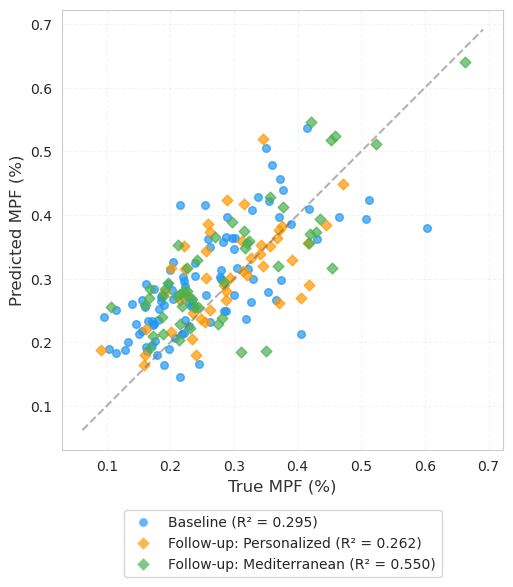

In [24]:
# Example usage
fig = plot_improved_comparison(
    figsize=(8, 6),
    predictions_file='./breacpntdata/full_predictions.csv',
    baseline_barcodes_file='./breacpntdata/bc_baseline_tube_barcodes.csv',
    followup_barcodes_file='./breacpntdata/bc_followup_tube_barcodes.csv',
    nova_baseline_file='./breacpntdata/Nova_scores_baseline.csv',
    nova_followup_file='./breacpntdata/Nova_scores_followup.csv',
    metric='NOVA1',
    output_file=figs_dir+ '/combined_comparison_plot_breast_cancer_change_NOVA1_FINAL_test.png',
    focus_mode=False, focus_threshold=0.1, scatter_size=30, metric_label='MPF (%)'
)

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score
import matplotlib.cm as cm
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score
import matplotlib.cm as cm
from collections import defaultdict
from matplotlib.legend_handler import HandlerLine2D

def create_clustered_visualization(predictions_file, baseline_barcodes_file, followup_barcodes_file, 
                                  nova_baseline_file, nova_followup_file,
                                  metric='NOVA1_percent', output_file=None, 
                                  figsize=(12, 10), n_clusters=8):
    """
    Create a cleaner visualization that clusters baseline and follow-up data points
    instead of showing all individual points.
    
    Parameters:
    -----------
    predictions_file : str
        Path to CSV file containing prediction data
    baseline_barcodes_file : str
        Path to CSV file containing baseline tube barcodes
    followup_barcodes_file : str
        Path to CSV file containing follow-up tube barcodes
    nova_baseline_file : str
        Path to CSV file containing baseline NOVA scores
    nova_followup_file : str
        Path to CSV file containing follow-up NOVA scores
    metric : str
        Column name to analyze in NOVA files (default: 'NOVA1_percent')
    output_file : str, optional
        Path to save the figure if provided
    figsize : tuple
        Figure size (width, height) in inches
    n_clusters : int
        Number of clusters to create for visualization
        
    Returns:
    --------
    matplotlib.figure.Figure
        The figure object containing the plot
    """
    # Define mapping between NOVA file columns and prediction file columns
    nova_to_pred_mapping = {
        'NOVA1_percent': 'Group 1',
        'NOVA2_percent': 'Group 2',
        'NOVA3_percent': 'Group 3',
        'NOVA4_percent': 'Group 4',
        'Combined_score': 'Combined_score',
        'NOVA1': 'Group 1',
        'NOVA2': 'Group 2',
        'NOVA3': 'Group 3',
        'NOVA4': 'Group 4'
    }
    
    # Get corresponding prediction column name
    pred_metric = nova_to_pred_mapping.get(metric, metric)
    
    # Define human-readable label for the metric
    metric_label_mapping = {
        'NOVA1_percent': 'NOVA Group 1 (%)',
        'NOVA2_percent': 'NOVA Group 2 (%)',
        'NOVA3_percent': 'NOVA Group 3 (%)',
        'NOVA4_percent': 'NOVA Group 4 (%)',
        'Combined_score': 'Combined Score',
        'NOVA1': 'NOVA Group 1',
        'NOVA2': 'NOVA Group 2',
        'NOVA3': 'NOVA Group 3',
        'NOVA4': 'NOVA Group 4'
    }
    metric_label = metric_label_mapping.get(metric, metric.replace('_', ' ').title())
    
    # Load data files
    predictions_df = pd.read_csv(predictions_file)
    baseline_barcodes_df = pd.read_csv(baseline_barcodes_file)
    followup_barcodes_df = pd.read_csv(followup_barcodes_file)
    nova_baseline_df = pd.read_csv(nova_baseline_file)
    nova_followup_df = pd.read_csv(nova_followup_file)
    
    # Create maps for quick access
    baseline_barcode_map = dict(zip(baseline_barcodes_df['RegistrationCode'], baseline_barcodes_df['Updated Tube Barcode']))
    followup_barcode_map = dict(zip(followup_barcodes_df['RegistrationCode'], followup_barcodes_df['Updated Tube Barcode']))
    nova_baseline_map = {row['RegistrationCode']: row for _, row in nova_baseline_df.iterrows()}
    nova_followup_map = {row['RegistrationCode']: row for _, row in nova_followup_df.iterrows()}
    
    # Create dicts mapping barcode to predictions
    predictions_map = {row['index']: row for _, row in predictions_df.iterrows()}
    
    # Create paired dataset
    pairs_data = []
    
    # Loop through registration codes
    reg_codes = set(baseline_barcodes_df['RegistrationCode']).intersection(
        set(followup_barcodes_df['RegistrationCode'])).intersection(
        set(nova_baseline_df['RegistrationCode'])).intersection(
        set(nova_followup_df['RegistrationCode']))
    
    for reg_code in reg_codes:
        baseline_barcode = baseline_barcode_map.get(reg_code)
        followup_barcode = followup_barcode_map.get(reg_code)
        
        # Skip if we don't have both barcodes
        if not baseline_barcode or not followup_barcode:
            continue
            
        # Skip if we don't have Nova data for both timepoints
        if reg_code not in nova_baseline_map or reg_code not in nova_followup_map:
            continue
            
        # Skip if we don't have predictions for both timepoints
        if baseline_barcode not in predictions_map or followup_barcode not in predictions_map:
            continue
            
        # Get prediction data
        baseline_pred_data = predictions_map[baseline_barcode]
        followup_pred_data = predictions_map[followup_barcode]
        
        # Get NOVA score data
        baseline_nova_data = nova_baseline_map[reg_code]
        followup_nova_data = nova_followup_map[reg_code]
        
        # Extract metrics
        baseline_true = baseline_nova_data[metric]
        followup_true = followup_nova_data[metric]
        baseline_pred = baseline_pred_data.get(pred_metric)
        followup_pred = followup_pred_data.get(pred_metric)
        
        # Skip if any value is missing
        if any(pd.isna(val) for val in [baseline_true, followup_true, baseline_pred, followup_pred]):
            continue
        
        # Determine if true value increased or decreased
        true_value_increased = followup_true > baseline_true
        
        # Add paired data
        pairs_data.append({
            'reg_code': reg_code,
            'baseline_true': baseline_true,
            'baseline_pred': baseline_pred,
            'followup_true': followup_true,
            'followup_pred': followup_pred,
            'true_value_increased': true_value_increased,
            'true_change': followup_true - baseline_true,
            'pred_change': followup_pred - baseline_pred
        })
    
    # Convert to DataFrame
    pairs_df = pd.DataFrame(pairs_data)
    
    if len(pairs_df) == 0:
        raise ValueError("No valid comparison data found after filtering")
    
    # Calculate R² scores for baseline and follow-up predictions
    baseline_r2 = r2_score(pairs_df['baseline_true'], pairs_df['baseline_pred'])
    followup_r2 = r2_score(pairs_df['followup_true'], pairs_df['followup_pred'])
    
    # Create clusters for baseline and followup data
    baseline_data = pairs_df[['baseline_true', 'baseline_pred']].values
    followup_data = pairs_df[['followup_true', 'followup_pred']].values
    
    # Create separate clusters for baseline and follow-up data
    baseline_kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    followup_kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    
    baseline_clusters = baseline_kmeans.fit_predict(baseline_data)
    followup_clusters = followup_kmeans.fit_predict(followup_data)
    
    # Calculate cluster centers and sizes
    baseline_centers = baseline_kmeans.cluster_centers_
    followup_centers = followup_kmeans.cluster_centers_
    
    # Count points in each cluster for size representation
    baseline_cluster_counts = np.bincount(baseline_clusters)
    followup_cluster_counts = np.bincount(followup_clusters)
    
    # Get cluster change statistics
    # Group data by baseline and followup clusters
    cluster_transitions = defaultdict(int)
    cluster_transitions_increased = defaultdict(int)
    cluster_transitions_decreased = defaultdict(int)
    
    for i, (b_cluster, f_cluster, increased) in enumerate(zip(baseline_clusters, followup_clusters, pairs_df['true_value_increased'])):
        if increased:
            cluster_transitions_increased[(b_cluster, f_cluster)] += 1
        else:
            cluster_transitions_decreased[(b_cluster, f_cluster)] += 1
        cluster_transitions[(b_cluster, f_cluster)] += 1
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Calculate marker sizes based on cluster sizes (scaled for visibility)
    size_scale = 30
    baseline_sizes = baseline_cluster_counts * size_scale
    followup_sizes = followup_cluster_counts * size_scale
    
    # Plot the clusters
    ax.scatter(baseline_centers[:, 0], baseline_centers[:, 1], 
               s=baseline_sizes, c='blue', alpha=0.6, label=f'Baseline (R² = {baseline_r2:.3f})')
    ax.scatter(followup_centers[:, 0], followup_centers[:, 1], 
               s=followup_sizes, c='orange', alpha=0.6, marker='D', label=f'Follow-up (R² = {followup_r2:.3f})')
    
    # Plot arrows between clusters if there are significant transitions
    min_transition_count = max(1, int(len(pairs_df) * 0.02))  # At least 2% of total pairs
    
    # Calculate average directions of change
    increase_transitions = []
    decrease_transitions = []
    
    for (b_cluster, f_cluster), count in cluster_transitions.items():
        if count >= min_transition_count:
            b_center = baseline_centers[b_cluster]
            f_center = followup_centers[f_cluster]
            
            # Get counts for increased and decreased transitions
            increased_count = cluster_transitions_increased.get((b_cluster, f_cluster), 0)
            decreased_count = cluster_transitions_decreased.get((b_cluster, f_cluster), 0)
            
            # Determine dominant direction
            if increased_count > decreased_count:
                increase_transitions.append((b_center, f_center, count))
            elif decreased_count > increased_count:
                decrease_transitions.append((b_center, f_center, count))
    
    # Plot transition arrows
    for b_center, f_center, count in increase_transitions:
        ax.annotate('', 
                   xy=(f_center[0], f_center[1]), 
                   xytext=(b_center[0], b_center[1]),
                   arrowprops=dict(arrowstyle="->", color='green', alpha=0.6, 
                                   linewidth=np.log1p(count)))
        
    for b_center, f_center, count in decrease_transitions:
        ax.annotate('', 
                   xy=(f_center[0], f_center[1]), 
                   xytext=(b_center[0], b_center[1]),
                   arrowprops=dict(arrowstyle="->", color='red', alpha=0.6, 
                                   linewidth=np.log1p(count)))
    
    # Add identity line (y=x)
    all_values = np.concatenate([
        pairs_df['baseline_true'].values, 
        pairs_df['baseline_pred'].values,
        pairs_df['followup_true'].values, 
        pairs_df['followup_pred'].values
    ])
    min_val = np.min(all_values)
    max_val = np.max(all_values)
    padding = (max_val - min_val) * 0.05
    ax.plot([min_val-padding, max_val+padding], [min_val-padding, max_val+padding], 'k--', alpha=0.5, label='Identity Line')

    # Set axis labels and title
    short_metric = metric.split('_')[0] if '_' in metric else metric
    ax.set_xlabel(f'True {metric_label}', fontsize=12)
    ax.set_ylabel(f'Predicted {metric_label}', fontsize=12)
    
    title = f'Clustered Baseline and Follow-up Comparison\n{metric_label}'
    ax.set_title(title, fontsize=14)
    
    # Add R² scores as text annotations on the plot
    text_x = min_val + (max_val - min_val) * 0.05
    text_y_baseline = max_val - (max_val - min_val) * 0.05
    text_y_followup = max_val - (max_val - min_val) * 0.10
    
    ax.text(text_x, text_y_baseline, f'Baseline R² = {baseline_r2:.3f}', 
            fontsize=11, color='blue', fontweight='bold', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    ax.text(text_x, text_y_followup, f'Follow-up R² = {followup_r2:.3f}', 
            fontsize=11, color='orange', fontweight='bold', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Create custom legend
    handles = []
    labels = []
    
    # Add scatter points with R² scores
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, alpha=0.6))
    labels.append(f'Baseline Clusters (R² = {baseline_r2:.3f})')
    
    handles.append(plt.Line2D([0], [0], marker='D', color='w', markerfacecolor='orange', markersize=8, alpha=0.6))
    labels.append(f'Follow-up Clusters (R² = {followup_r2:.3f})')
    
    # Add identity line
    handles.append(plt.Line2D([0], [0], linestyle='--', color='k', alpha=0.5))
    labels.append('Identity Line')
    
    # Add arrow lines for increased and decreased true values
    handles.append(plt.Line2D([0], [0], color='green', alpha=0.6, marker='>'))
    labels.append('True Value Increased')
    
    handles.append(plt.Line2D([0], [0], color='red', alpha=0.6, marker='>'))
    labels.append('True Value Decreased')
    
    # Add reference circles for sample sizes
    # Calculate some representative sample sizes for legend
    max_cluster_size = max(max(baseline_cluster_counts), max(followup_cluster_counts))
    small_size = max(1, int(max_cluster_size * 0.2))  # Approx 20% of max
    medium_size = max(1, int(max_cluster_size * 0.5))  # Approx 50% of max
    large_size = max_cluster_size
    
    # Add divider for size reference section
    handles.append(plt.Line2D([0], [0], color='w', alpha=0))
    labels.append('')
    
    # Add sample size reference circles
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
                             markersize=np.sqrt(small_size * size_scale / np.pi)))
    labels.append(f'{small_size} subjects')
    
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
                             markersize=np.sqrt(medium_size * size_scale / np.pi)))
    labels.append(f'{medium_size} subjects')
    
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
                             markersize=np.sqrt(large_size * size_scale / np.pi)))
    labels.append(f'{large_size} subjects')
    
    # Note about clustering
    ax.text(0.5, -0.13, f'Note: Points are clustered into {n_clusters} groups for clarity.\nCircle/diamond size represents number of subjects in each cluster.', 
            transform=ax.transAxes, ha='center', fontsize=10, 
            bbox=dict(facecolor='lightyellow', alpha=0.5, boxstyle='round'))
    
    # Add the legend with two rows for better organization
    ax.legend(handles=handles, labels=labels, loc='upper center', 
              bbox_to_anchor=(0.5, -0.25), ncol=3, fontsize=10, 
              handler_map={plt.Line2D: HandlerLine2D(numpoints=1)})
    
    # Add gridlines
    ax.grid(True, linestyle='--', alpha=0.3)
    
    # Equal aspect ratio for better visual comparison
    ax.set_aspect('equal')
    
    # Tight layout
    plt.tight_layout()
    
    # Save figure if output file is provided
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
    
    return fig


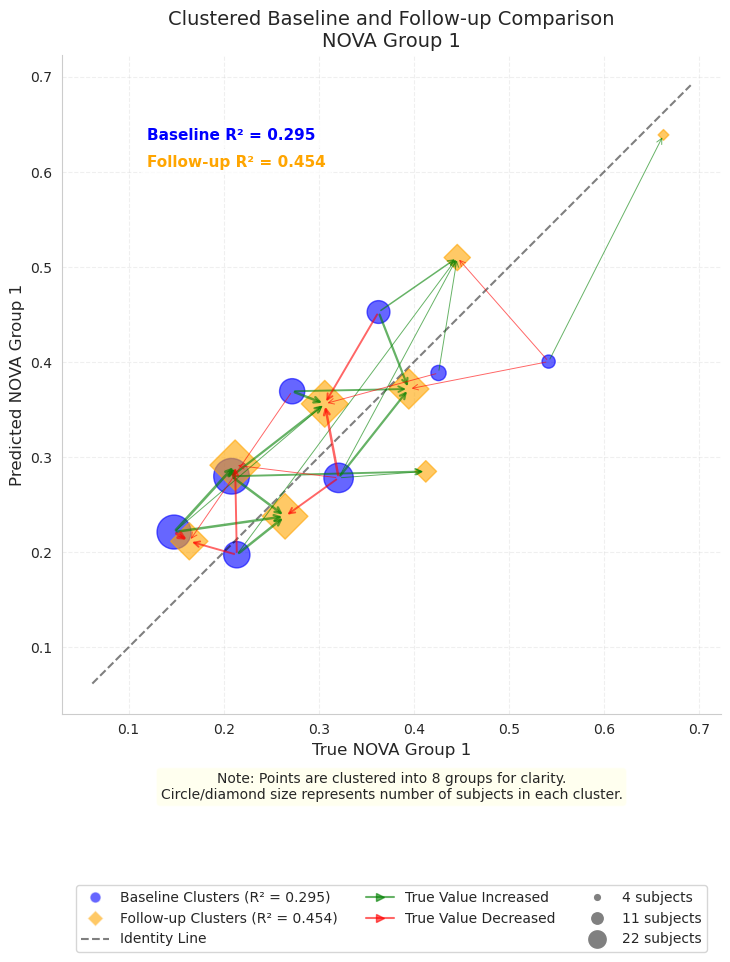

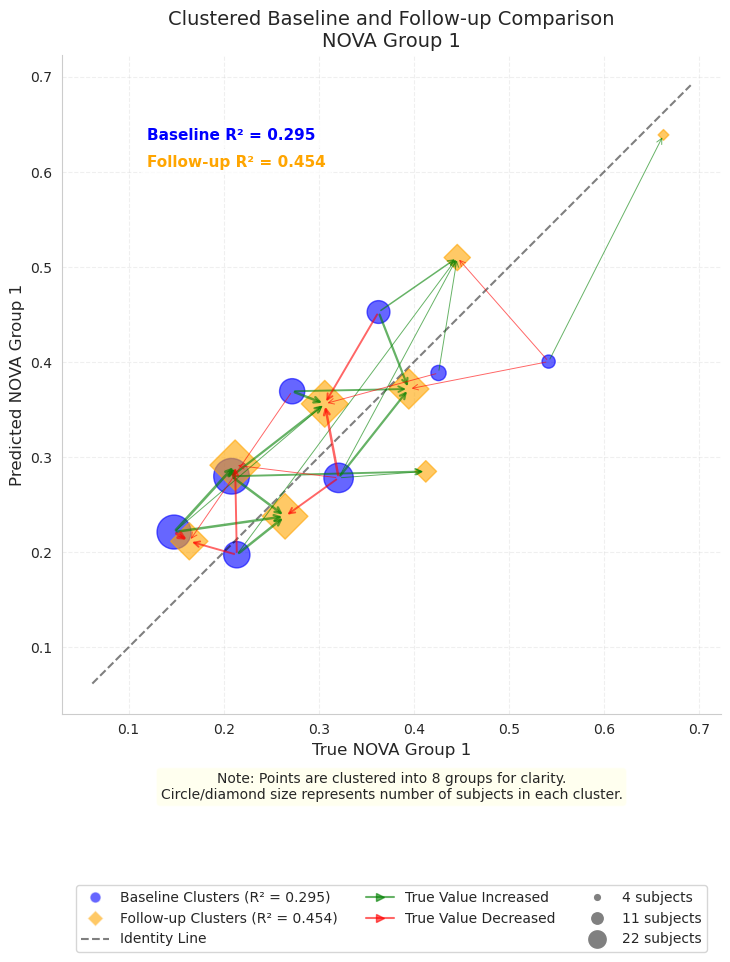

In [141]:
create_clustered_visualization(
    predictions_file='./breacpntdata/full_predictions.csv',
    baseline_barcodes_file='./breacpntdata/bc_baseline_tube_barcodes.csv',
    followup_barcodes_file='./breacpntdata/bc_followup_tube_barcodes.csv',
    nova_baseline_file='./breacpntdata/Nova_scores_baseline.csv',
    nova_followup_file='./breacpntdata/Nova_scores_followup.csv',
    metric='NOVA1',
    output_file=figs_dir + '/clustered_comparison_plot_breast_cancer_change_NOVA1_1.png',
    n_clusters=8
)

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import matplotlib.cm as cm
from scipy.stats import gaussian_kde
import matplotlib.colors as mcolors

def create_heatmap_visualization(predictions_file, baseline_barcodes_file, followup_barcodes_file, 
                               nova_baseline_file, nova_followup_file,
                               metric='NOVA1_percent', output_file=None, 
                               figsize=(12, 10)):
    """
    Create a visualization using heatmaps to represent data density instead of individual points.
    
    Parameters:
    -----------
    predictions_file : str
        Path to CSV file containing prediction data
    baseline_barcodes_file : str
        Path to CSV file containing baseline tube barcodes
    followup_barcodes_file : str
        Path to CSV file containing follow-up tube barcodes
    nova_baseline_file : str
        Path to CSV file containing baseline NOVA scores
    nova_followup_file : str
        Path to CSV file containing follow-up NOVA scores
    metric : str
        Column name to analyze in NOVA files (default: 'NOVA1_percent')
    output_file : str, optional
        Path to save the figure if provided
    figsize : tuple
        Figure size (width, height) in inches
        
    Returns:
    --------
    matplotlib.figure.Figure
        The figure object containing the plot
    """
    # Define mapping between NOVA file columns and prediction file columns
    nova_to_pred_mapping = {
        'NOVA1_percent': 'Group 1',
        'NOVA2_percent': 'Group 2',
        'NOVA3_percent': 'Group 3',
        'NOVA4_percent': 'Group 4',
        'Combined_score': 'Combined_score',
        'NOVA1': 'Group 1',
        'NOVA2': 'Group 2',
        'NOVA3': 'Group 3',
        'NOVA4': 'Group 4'
    }
    
    # Get corresponding prediction column name
    pred_metric = nova_to_pred_mapping.get(metric, metric)
    
    # Define human-readable label for the metric
    metric_label_mapping = {
        'NOVA1_percent': 'NOVA Group 1 (%)',
        'NOVA2_percent': 'NOVA Group 2 (%)',
        'NOVA3_percent': 'NOVA Group 3 (%)',
        'NOVA4_percent': 'NOVA Group 4 (%)',
        'Combined_score': 'Combined Score',
        'NOVA1': 'NOVA Group 1',
        'NOVA2': 'NOVA Group 2',
        'NOVA3': 'NOVA Group 3',
        'NOVA4': 'NOVA Group 4'
    }
    metric_label = metric_label_mapping.get(metric, metric.replace('_', ' ').title())
    
    # Load data files
    predictions_df = pd.read_csv(predictions_file)
    baseline_barcodes_df = pd.read_csv(baseline_barcodes_file)
    followup_barcodes_df = pd.read_csv(followup_barcodes_file)
    nova_baseline_df = pd.read_csv(nova_baseline_file)
    nova_followup_df = pd.read_csv(nova_followup_file)
    
    # Create maps for quick access
    baseline_barcode_map = dict(zip(baseline_barcodes_df['RegistrationCode'], baseline_barcodes_df['Updated Tube Barcode']))
    followup_barcode_map = dict(zip(followup_barcodes_df['RegistrationCode'], followup_barcodes_df['Updated Tube Barcode']))
    nova_baseline_map = {row['RegistrationCode']: row for _, row in nova_baseline_df.iterrows()}
    nova_followup_map = {row['RegistrationCode']: row for _, row in nova_followup_df.iterrows()}
    
    # Create dicts mapping barcode to predictions
    predictions_map = {row['index']: row for _, row in predictions_df.iterrows()}
    
    # Create paired dataset
    pairs_data = []
    
    # Loop through registration codes
    reg_codes = set(baseline_barcodes_df['RegistrationCode']).intersection(
        set(followup_barcodes_df['RegistrationCode'])).intersection(
        set(nova_baseline_df['RegistrationCode'])).intersection(
        set(nova_followup_df['RegistrationCode']))
    
    for reg_code in reg_codes:
        baseline_barcode = baseline_barcode_map.get(reg_code)
        followup_barcode = followup_barcode_map.get(reg_code)
        
        # Skip if we don't have both barcodes
        if not baseline_barcode or not followup_barcode:
            continue
            
        # Skip if we don't have Nova data for both timepoints
        if reg_code not in nova_baseline_map or reg_code not in nova_followup_map:
            continue
            
        # Skip if we don't have predictions for both timepoints
        if baseline_barcode not in predictions_map or followup_barcode not in predictions_map:
            continue
            
        # Get prediction data
        baseline_pred_data = predictions_map[baseline_barcode]
        followup_pred_data = predictions_map[followup_barcode]
        
        # Get NOVA score data
        baseline_nova_data = nova_baseline_map[reg_code]
        followup_nova_data = nova_followup_map[reg_code]
        
        # Extract metrics
        baseline_true = baseline_nova_data[metric]
        followup_true = followup_nova_data[metric]
        baseline_pred = baseline_pred_data.get(pred_metric)
        followup_pred = followup_pred_data.get(pred_metric)
        
        # Skip if any value is missing
        if any(pd.isna(val) for val in [baseline_true, followup_true, baseline_pred, followup_pred]):
            continue
        
        # Determine if true value increased or decreased
        true_value_increased = followup_true > baseline_true
        
        # Add paired data
        pairs_data.append({
            'reg_code': reg_code,
            'baseline_true': baseline_true,
            'baseline_pred': baseline_pred,
            'followup_true': followup_true,
            'followup_pred': followup_pred,
            'true_value_increased': true_value_increased,
            'true_change': followup_true - baseline_true,
            'pred_change': followup_pred - baseline_pred
        })
    
    # Convert to DataFrame
    pairs_df = pd.DataFrame(pairs_data)
    
    if len(pairs_df) == 0:
        raise ValueError("No valid comparison data found after filtering")
    
    # Calculate R² scores for baseline and follow-up predictions
    baseline_r2 = r2_score(pairs_df['baseline_true'], pairs_df['baseline_pred'])
    followup_r2 = r2_score(pairs_df['followup_true'], pairs_df['followup_pred'])
    
    # Extract data for baseline and followup
    baseline_data = pairs_df[['baseline_true', 'baseline_pred']].values
    followup_data = pairs_df[['followup_true', 'followup_pred']].values
    
    # Get data ranges for plotting
    all_values = np.concatenate([
        pairs_df['baseline_true'].values, 
        pairs_df['baseline_pred'].values,
        pairs_df['followup_true'].values, 
        pairs_df['followup_pred'].values
    ])
    min_val = np.min(all_values)
    max_val = np.max(all_values)
    padding = (max_val - min_val) * 0.05
    x_range = [min_val-padding, max_val+padding]
    y_range = [min_val-padding, max_val+padding]
    
    # Create the plot with subplots
    fig, axs = plt.subplots(1, 3, figsize=figsize, gridspec_kw={'width_ratios': [1, 1, 0.05]})
    
    # Function to calculate and plot KDE heatmap
    def plot_kde_heatmap(ax, data, cmap, title, r2_score):
        # Calculate the kernel density estimate on a grid
        x = np.linspace(x_range[0], x_range[1], 100)
        y = np.linspace(y_range[0], y_range[1], 100)
        X, Y = np.meshgrid(x, y)
        positions = np.vstack([X.ravel(), Y.ravel()])
        
        # Calculate kernel density estimate
        if len(data) > 1:  # Ensure we have enough data points
            kernel = gaussian_kde(data.T)
            Z = np.reshape(kernel(positions), X.shape)
        else:
            Z = np.zeros_like(X)
        
        # Plot heatmap
        im = ax.imshow(Z, cmap=cmap, origin='lower', aspect='auto', 
                       extent=[x_range[0], x_range[1], y_range[0], y_range[1]],
                       alpha=0.8)
        
        # Add identity line
        ax.plot(x_range, y_range, 'k--', alpha=0.7)
        
        # Set title and axes
        ax.set_title(f"{title}\nR² = {r2_score:.3f}", fontsize=12)
        ax.set_xlabel(f'True {metric_label}', fontsize=11)
        ax.set_ylabel(f'Predicted {metric_label}', fontsize=11)
        
        # Show grid
        ax.grid(True, linestyle='--', alpha=0.3)
        
        return im
    
    # Plot baseline heatmap
    im1 = plot_kde_heatmap(axs[0], baseline_data, plt.cm.Blues, "Baseline", baseline_r2)
    
    # Plot followup heatmap
    im2 = plot_kde_heatmap(axs[1], followup_data, plt.cm.Oranges, "Follow-up", followup_r2)
    
    # Add a colorbar
    fig.colorbar(im2, cax=axs[2], label='Density')
    
    # Create arrows showing the average direction of change
    avg_baseline = np.mean(baseline_data, axis=0)
    avg_followup = np.mean(followup_data, axis=0)
    
    # Calculate the average change in true values
    avg_true_change = avg_followup[0] - avg_baseline[0]
    color = 'green' if avg_true_change > 0 else 'red'
    
    # Draw an arrow between the average points on both plots
    arrow_props = dict(arrowstyle="fancy", color=color, 
                       connectionstyle="arc3,rad=0.3", 
                       alpha=0.7, linewidth=2)
    
    # Add annotations to explain the direction of change
    fig.text(0.5, 0.03, 
             f"Average direction of change: {'Increase' if avg_true_change > 0 else 'Decrease'} "
             f"in true {metric_label}",
             ha='center', fontsize=12, 
             color=color,
             bbox=dict(facecolor='white', alpha=0.7, edgecolor=color, boxstyle='round'))
    
    # Add note about density visualization
    fig.text(0.5, 0.97, 
             "Density visualization: darker areas indicate higher concentration of subjects",
             ha='center', fontsize=12, 
             bbox=dict(facecolor='lightyellow', alpha=0.5, boxstyle='round'))
    
    # Main title
    fig.suptitle(f'Density Comparison of Baseline vs. Follow-up\n{metric_label}', 
                 fontsize=14, fontweight='bold')
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    
    # Save figure if output file is provided
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
    
    return fig

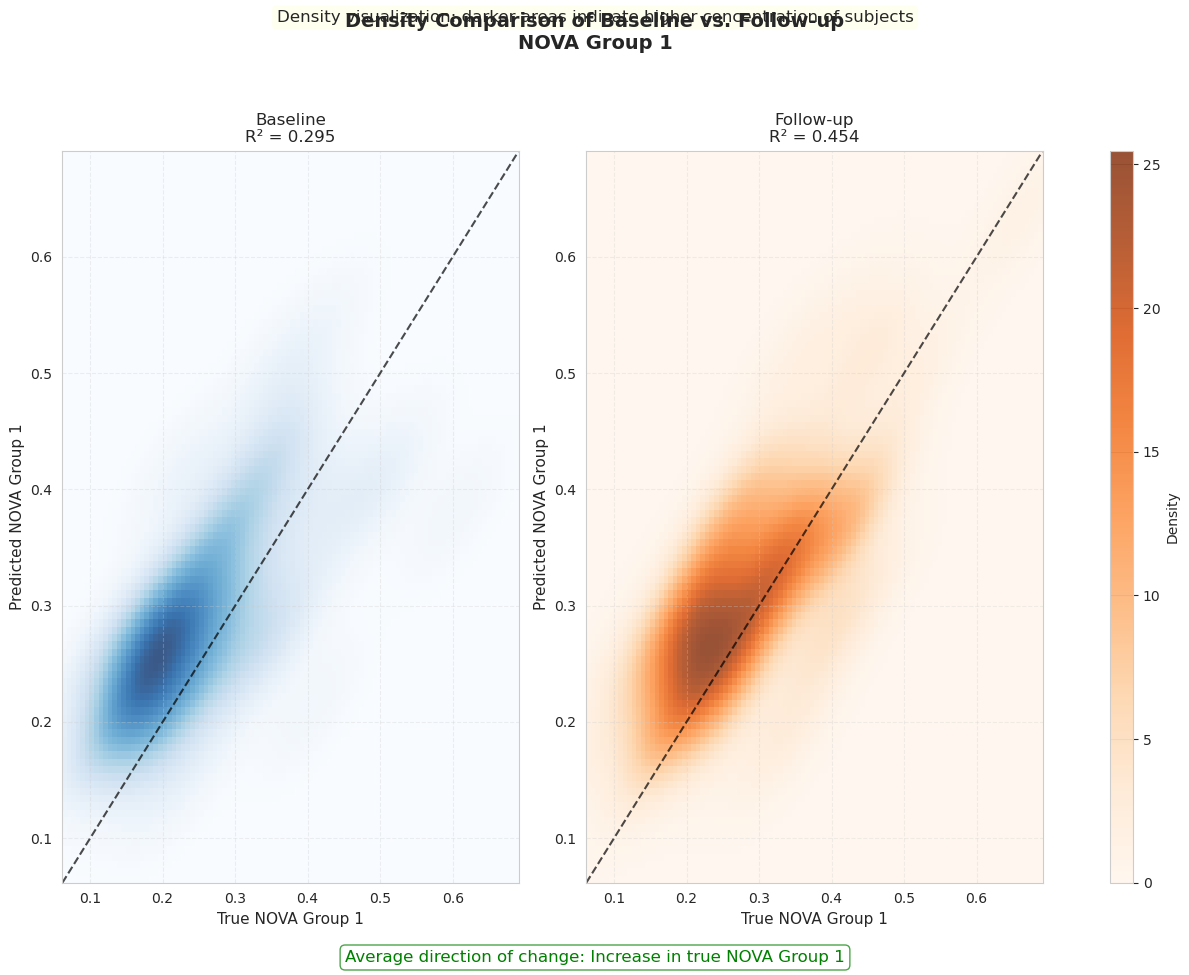

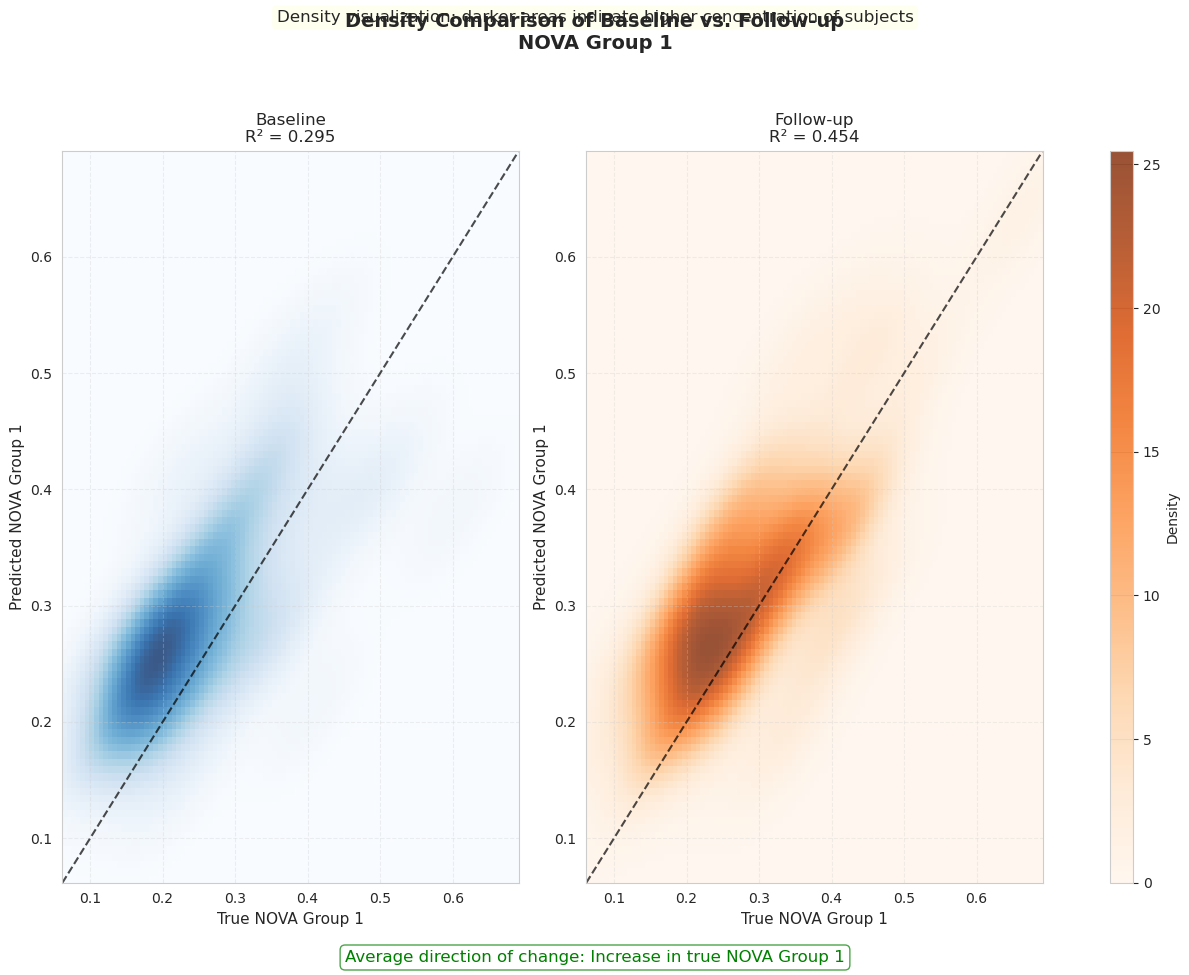

In [143]:
create_heatmap_visualization(
    predictions_file='./breacpntdata/full_predictions.csv',
    baseline_barcodes_file='./breacpntdata/bc_baseline_tube_barcodes.csv',
    followup_barcodes_file='./breacpntdata/bc_followup_tube_barcodes.csv',
    nova_baseline_file='./breacpntdata/Nova_scores_baseline.csv',
    nova_followup_file='./breacpntdata/Nova_scores_followup.csv',
    metric='NOVA1',
    output_file=figs_dir + '/heatmap_comparison_plot_breast_cancer_change_NOVA1_1.png'
)